# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
print(os.chdir('gdrive/My Drive'))
print(os.listdir())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
None
['appdata', 'appdata (1)', 'Facebook Hacks', 'Vashu', 'Kamna car loan', 'Python', 'WhatsApp Video 2018-02-28 at 2.25.22 PM.mp4', 'Fee receipt 3rd year.pdf', 'Classroom', 'iris.csv', 'YuuDrive', 'Cognitive Class PY0101EN Certificate _ Cognitive Class.pdf', 'database.sqlite', 'Colab Notebooks', '0161CSE107 RISHABH MALIK.pdf', 'Reviews.csv', 'Untitled document.gdoc', 'Assignment 3.ipynb', 'KNN Assignment_.pdf', 'KNN Assignment_.ipynb', 'Assignments_AFR_2018

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:11<00:00, 1897.59it/s]


In [24]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
final['CleanedText']=preprocessed_reviews

In [26]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
#Sorting data according to Time in ascending order
total_points=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
total_points = total_points[:100000]

In [29]:
total_points['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
names = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text','CleanedText']

X = total_points[names]
y = total_points['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_tr   , X_cv  , y_tr   , y_cv   = train_test_split(X_train , y_train , test_size=0.3 ,random_state=0)

# [4] Featurization

## [4.1] BAG OF WORDS

In [59]:
#BoW
count_vect = CountVectorizer(min_df=15) #in scikit-learn
bow = count_vect.fit(X_tr['CleanedText'].values)

bow_train = bow.fit_transform(X_tr['CleanedText'].values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_cv = bow.transform(X_cv['CleanedText'])
bow_test = bow.transform(X_test['CleanedText'])
print("the type of count vectorizer CV :",type(bow_cv))
print("the shape of out text BOW CV vectorizer ",bow_cv.get_shape())
print("the number of unique words in CV ", bow_cv.get_shape()[1])

some feature names  ['ability', 'able', 'abroad', 'absence', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absorbs']
the type of count vectorizer CV : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW CV vectorizer  (21000, 6854)
the number of unique words in CV  6854


## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=15)
tfidf = tf_idf_vect.fit(X_tr['CleanedText'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

tfidf_train = tfidf.fit_transform(X_tr['CleanedText'])
tfidf_cv    = tfidf.transform(X_cv['CleanedText'])
tfidf_test  = tfidf.transform(X_test['CleanedText'])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able keep', 'able make']


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_train=[]
for sent in X_tr['CleanedText']:
    list_of_sent_train.append(sent.split())

In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_train.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.880715548992157), ('fantastic', 0.8672329187393188), ('awesome', 0.8602523803710938), ('good', 0.826729953289032), ('excellent', 0.791886568069458), ('wonderful', 0.7793072462081909), ('incredible', 0.7676927447319031), ('decent', 0.7527187466621399), ('amazing', 0.7449739575386047), ('geat', 0.725753903388977)]
[('greatest', 0.7954636812210083), ('best', 0.7856841087341309), ('tastiest', 0.6405529379844666), ('superior', 0.6344375014305115), ('nastiest', 0.6337081789970398), ('terrible', 0.6032911539077759), ('surpasses', 0.6029099822044373), ('honestly', 0.5995387434959412), ('richest', 0.592534065246582), ('disgusting', 0.5817214846611023)]


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
sent_vectors_train = np.nan_to_num(sent_vectors_train)

49000
50


In [34]:
i=0
list_of_sent_cv=[]
for sent in X_cv['CleanedText'].values:
    list_of_sent_cv.append(sent.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
sent_vectors_cv = np.nan_to_num(sent_vectors_cv)

21000
50


In [35]:
i=0
list_of_sent_test=[]
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
sent_vectors_test = np.nan_to_num(sent_vectors_test)

30000
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 5000)
tfidf = tfidf_vect.fit_transform(X_tr['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [40]:
w2v_words_list = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_list))
print(type(w2v_words_list))

number of words that occured minimum 5 times  13481
<class 'list'>


In [42]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_train = []
row = 0
for sent in tqdm(X_tr['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list and word in features):
            vec = w2v_model_train.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_train.append(sent_vec)
    #row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
print(len(tfidf_sent_vectors_train))
#  return tfidf_sent_vectors_train

100%|██████████| 49000/49000 [04:20<00:00, 188.30it/s]


49000


In [0]:
tfidf_sent_vectors_train = np.nan_to_num(tfidf_sent_vectors_train)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [46]:
import math
C_values=[pow(10,j) for j in range (-4,4,1)]
print(C_values)
C_values_log=[(math.log(pow(10,j))) for j in range (-4,4,1)]
print(C_values_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137]


Maximum AUC value is  0.9287122419598413
Best Hyperparameter C is : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


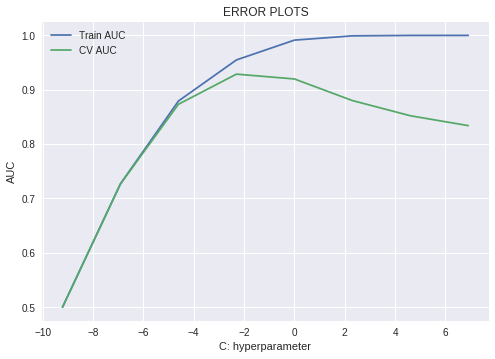

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l1' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(bow_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Applying Logistic Regression on CV Data

Accuracy on CV is :  93.7583574098881


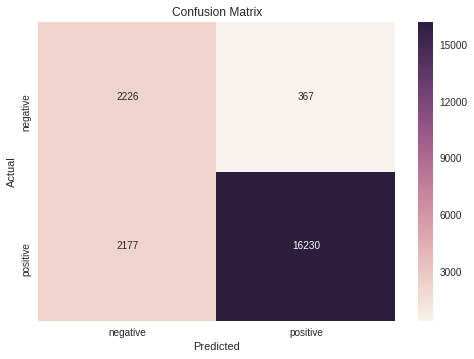

In [0]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l1' ,C = 0.1 , class_weight='balanced' )
clf.fit(bow_train , y_tr )
pred = clf.predict_proba(bow_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Applying Logistic Regression on Test Data

Accuracy on Test is :  92.9123195183478


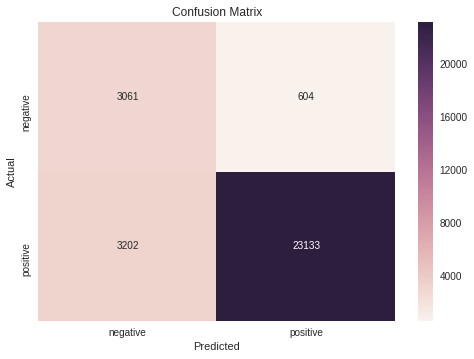

In [0]:
pred = clf.predict_proba(bow_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

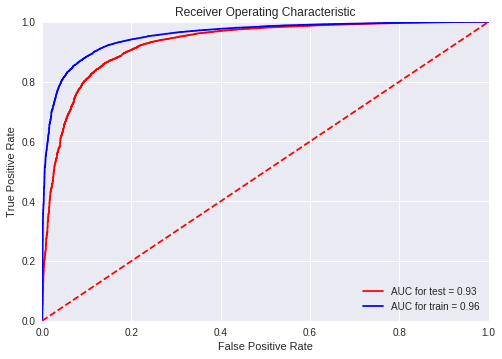

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(bow_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
clf = LogisticRegression(C= 1 , penalty='l1' , class_weight='balanced');
clf.fit(bow_train, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

4018


In [0]:
clf = LogisticRegression(C= 10 , penalty='l1' , class_weight='balanced');
clf.fit(bow_train, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

5893


In [0]:
clf = LogisticRegression(C= 0.1 , penalty='l1' , class_weight='balanced');
clf.fit(bow_train, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

1102


In [0]:
clf = LogisticRegression(C= 100 , penalty='l1' , class_weight='balanced');
clf.fit(bow_train, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

6647


In [0]:
clf = LogisticRegression(C= 0.01 , penalty='l1' , class_weight='balanced');
clf.fit(bow_train, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

171


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Maximum AUC value is  0.932576307643124
Best Hyperparameter C is : 0.1


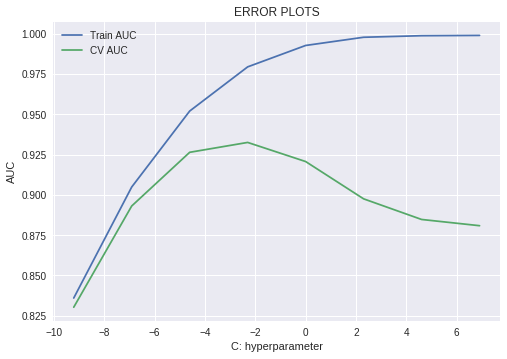

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l2' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(bow_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", max_x)


plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on CV is :  93.91469098333225


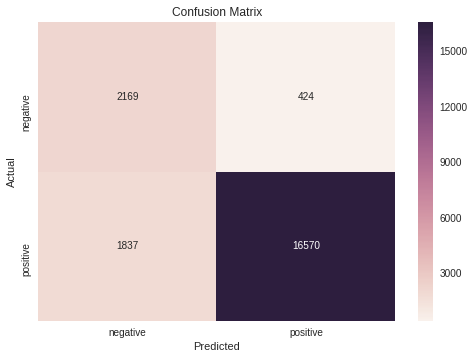

In [0]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l2' ,C = 0.1, class_weight='balanced' )
clf.fit(bow_train , y_tr )
pred = clf.predict_proba(bow_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy on Test is :  93.33376520542458


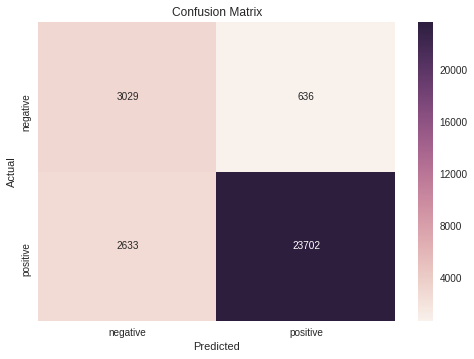

In [0]:
pred = clf.predict_proba(bow_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

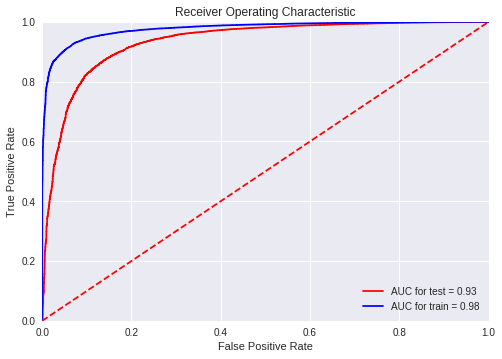

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(bow_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
w = clf.coef_
print(w)

[[-0.01629509  0.24361578  0.02428594 ... -0.0437944  -0.08878072
   0.17426313]]


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
#using numpy function to generate a random variable
rand = np.random.normal(loc =0 , scale =0.01 , size =1)

#Adding the random value to our bow_train.data as described in the instructions
bow_train.data= bow_train.data + rand

#we are using l2 reg here because in the video sir said that most of the time we use l2 reg instead of l1 reg as it creates sparsity
lg=LogisticRegression( penalty='l2' , class_weight='balanced' )
mod = GridSearchCV(lg , parameters , cv=4 ,scoring='roc_auc')
mod.fit(bow_train,y_tr)
print(mod.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [0]:
clf_noise = LogisticRegression(penalty='l2' ,class_weight='balanced' , C=0.1)
clf_noise.fit(bow_train , y_tr)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
w_noise = clf_noise.coef_
print(w_noise)

[[-0.01605847  0.2422119   0.02425243 ... -0.04463316 -0.08839317
   0.17516308]]


In [0]:
weight_diff = (abs(w-w_noise)/w)*100
def percentile(start,end,step,weights):
    for i in np.arange(start,end,step):
        print('The {}th percentile is : {}' .format(i,np.percentile(w,i)))
percentile(0,101,10,weight_diff)

The 0th percentile is : -2.3639742310195713
The 10th percentile is : -0.2800597648408463
The 20th percentile is : -0.16109962749020124
The 30th percentile is : -0.07879484682131747
The 40th percentile is : -0.017356579623631737
The 50th percentile is : 0.031612469092651814
The 60th percentile is : 0.07619436843688657
The 70th percentile is : 0.1221956462730259
The 80th percentile is : 0.1801901559972485
The 90th percentile is : 0.27811864884256066
The 100th percentile is : 1.378250252012889


In [0]:
percentile(90,100.1,1,weight_diff)

The 90.0th percentile is : 0.27811864884256066
The 91.0th percentile is : 0.296050222384097
The 92.0th percentile is : 0.3150965666173261
The 93.0th percentile is : 0.33623111670672845
The 94.0th percentile is : 0.3598149339786785
The 95.0th percentile is : 0.38498864261678933
The 96.0th percentile is : 0.42162886726073096
The 97.0th percentile is : 0.46748921478063415
The 98.0th percentile is : 0.5355972419744315
The 99.0th percentile is : 0.6498897795668155
The 100.0th percentile is : 1.378250252012889


In [0]:
percentile(99,100.1,0.1,weight_diff)

The 99.0th percentile is : 0.6498897795668155
The 99.1th percentile is : 0.6627870760725973
The 99.19999999999999th percentile is : 0.7061511483876204
The 99.29999999999998th percentile is : 0.7222223826104068
The 99.39999999999998th percentile is : 0.7392732664345074
The 99.49999999999997th percentile is : 0.7847464078335695
The 99.59999999999997th percentile is : 0.8738185669988356
The 99.69999999999996th percentile is : 0.9654383131650649
The 99.79999999999995th percentile is : 1.099622294551507
The 99.89999999999995th percentile is : 1.2374452345670193
The 99.99999999999994th percentile is : 1.378250252012744


**There is change between between percentile 99.7 to 99.9**

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
feat = count_vect.get_feature_names()
coefs = sorted(zip(clf.coef_[0],feat))
for i in coefs[-10:]:
    print(i)

(1.1735662092908585, 'great')
(1.2049568129936679, 'perfect')
(1.2371449636000451, 'loves')
(1.2391876232393761, 'wonderful')
(1.2481012325424672, 'yummy')
(1.2556452773342426, 'best')
(1.321952178705738, 'beat')
(1.3262940511591876, 'highly')
(1.338360659004135, 'delicious')
(1.378250252012889, 'excellent')


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
for i in coefs[:10]:
    print(i)

(-2.3639742310195713, 'worst')
(-1.638161941404577, 'terrible')
(-1.614576459588701, 'disappointing')
(-1.6009731956353748, 'sounded')
(-1.586775369952697, 'bland')
(-1.5439269416530772, 'disappointment')
(-1.5284734178884218, 'horrible')
(-1.5076504321168909, 'disappointed')
(-1.4766715842922418, 'awful')
(-1.2837209581790034, 'threw')


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

Maximum AUC value is  0.9500530465295157
Best Hyperparameter C is : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


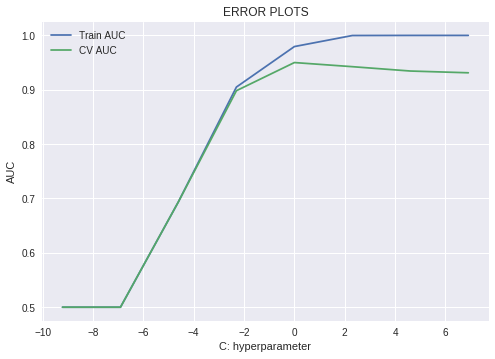

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l1' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(tfidf_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Checking Accuracy on CV Data

Accuracy on CV is :  95.61555634812635


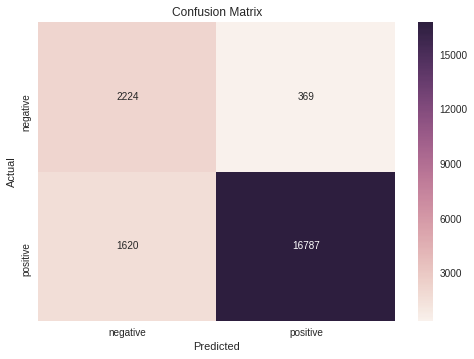

In [0]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l1' ,C = 1 , class_weight='balanced' )
clf.fit(tfidf_train , y_tr )
pred = clf.predict_proba(tfidf_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Checking Accuracy on Test Data

Accuracy on Test is :  95.10879265503166


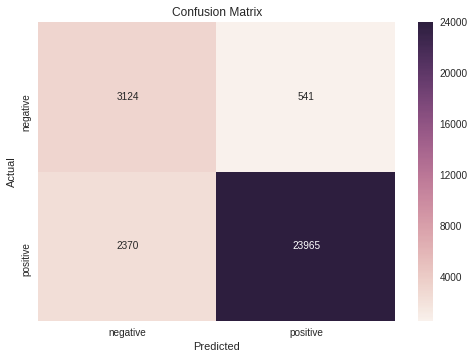

In [0]:
pred = clf.predict_proba(tfidf_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

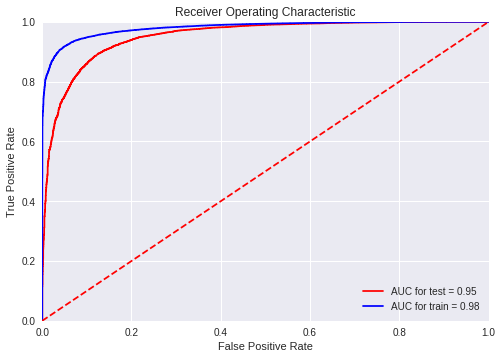

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(tfidf_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Maximum AUC value is  0.9552087179441557
Best Hyperparameter C is : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


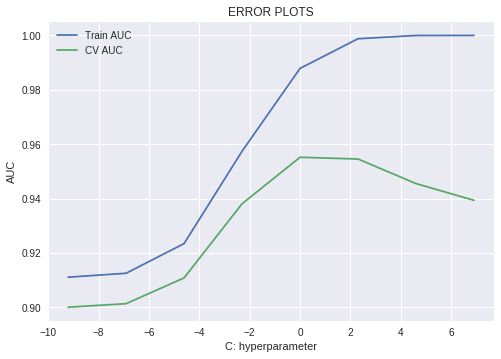

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l2' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(tfidf_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Checking Accuracy on CV data

Accuracy on CV is :  95.8769573464345


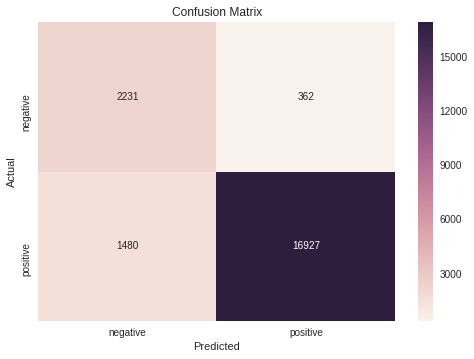

In [0]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l2' ,C = 1 , class_weight='balanced' )
clf.fit(tfidf_train , y_tr )
pred = clf.predict_proba(tfidf_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Checking Accuracy on Test Data

Accuracy on Test is :  95.5341557552482


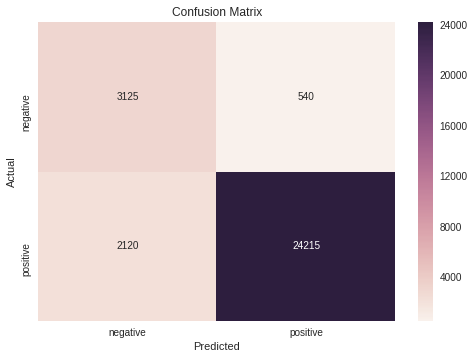

In [0]:
pred = clf.predict_proba(tfidf_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

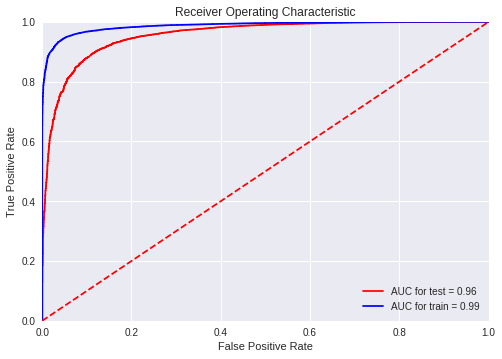

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(tfidf_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
feat = count_vect.get_feature_names()
coefs = sorted(zip(clf.coef_[0],feat))
for i in coefs[-10:]:
    print(i)

(3.9072822923037367, 'strawberries')
(4.048396070965396, 'toasty')
(4.330119376163676, 'barista')
(4.532356234571034, 'become')
(5.53029916277506, 'reviewers')
(6.213202351306219, 'rainforest')
(6.342800084144328, 'truffles')
(7.56364518365132, 'material')
(8.62891145309961, 'combined')
(11.251694446211912, 'wean')


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
for i in coefs[:10]:
    print(i)

(-8.059340891580243, 'mushroom')
(-5.625371082937073, 'crunchies')
(-5.451911584437369, 'caribou')
(-5.194923542285403, 'mustard')
(-5.159224871444994, 'mustards')
(-4.745012250576655, 'caution')
(-3.6796575472630053, 'nature')
(-3.387694103654077, 'flavour')
(-3.2764748682949794, 'crema')
(-3.2570881016750985, 'fruity')


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

Maximum AUC value is  0.8931039434033964
Best Hyperparameter C is : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


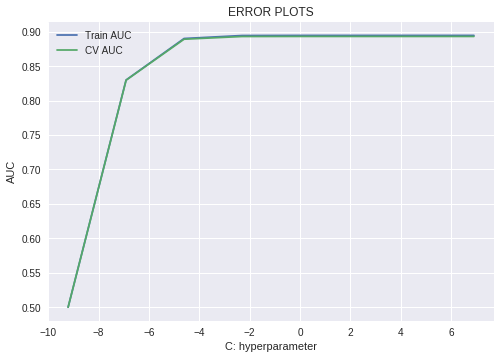

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l1' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(sent_vectors_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Checking Accuracy on CV Data

Accuracy on CV is :  89.5241001705638


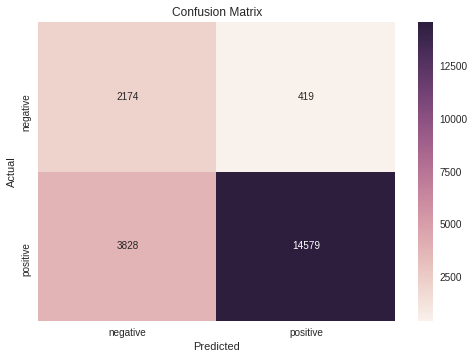

In [0]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l1' ,C = 1 , class_weight='balanced' )
clf.fit(sent_vectors_cv , y_cv )
pred = clf.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Checking Accuracy on Test Data

Accuracy on Test is :  89.05809266738692


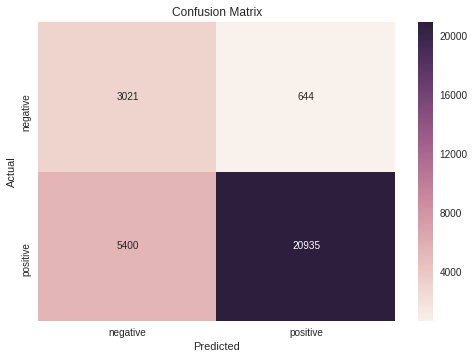

In [0]:
pred = clf.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

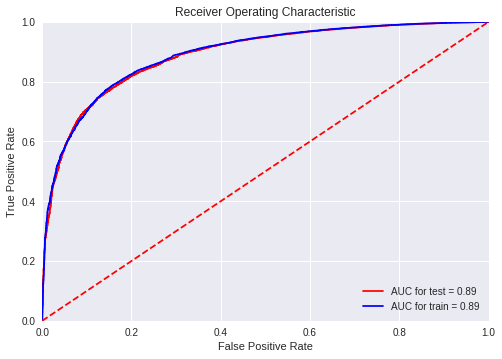

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(sent_vectors_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Maximum AUC value is  0.8931573811629351
Best Hyperparameter C is : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


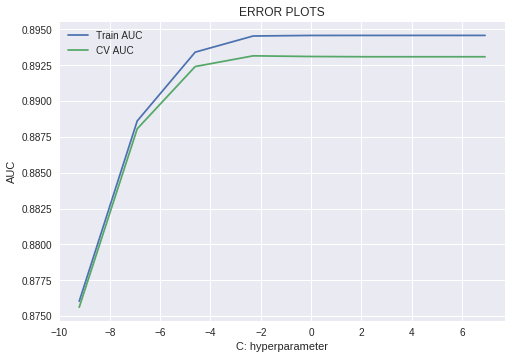

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l2' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(sent_vectors_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Checking Accuracy on CV Data

Accuracy on CV is :  89.51533826638456


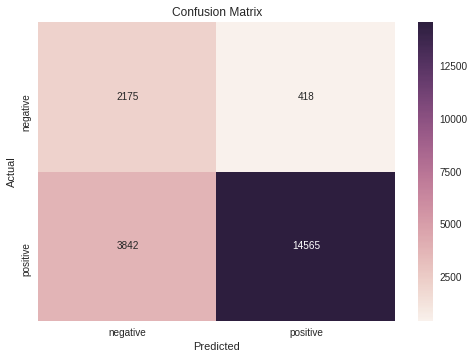

In [0]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l2' ,C = 0.1 , class_weight='balanced' )
clf.fit(sent_vectors_cv , y_cv )
pred = clf.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Checking Accuracy on Test Data

Accuracy on Test is :  89.05812893013749


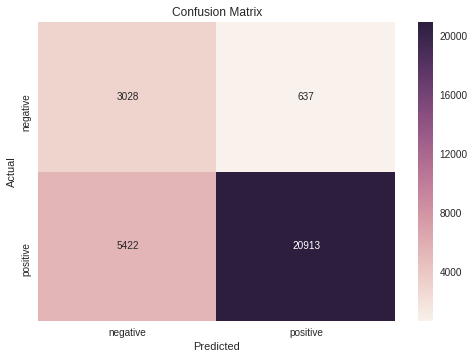

In [0]:
pred = clf.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

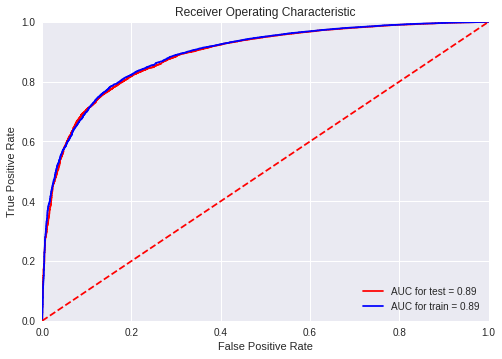

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(sent_vectors_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Maximum AUC value is  0.8667486975730158
Best Hyperparameter C is : LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


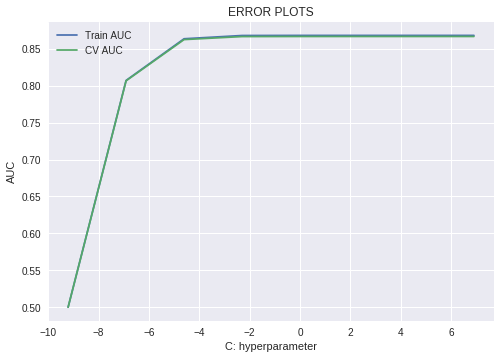

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l1' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Checking Accuracy on CV Data

Accuracy on CV is :  86.86043939713322


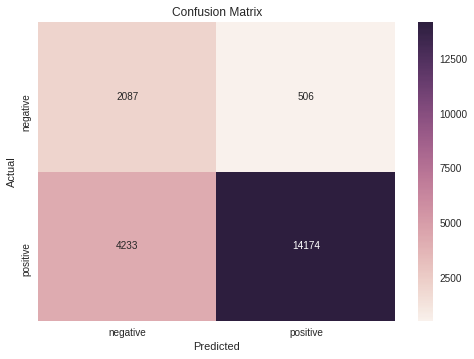

In [52]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l1' ,C = 1000 , class_weight='balanced' )
clf.fit(tfidf_sent_vectors_cv , y_cv )
pred = clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Checking Accuracy on Test Data

Accuracy on Test is :  86.12949739050657


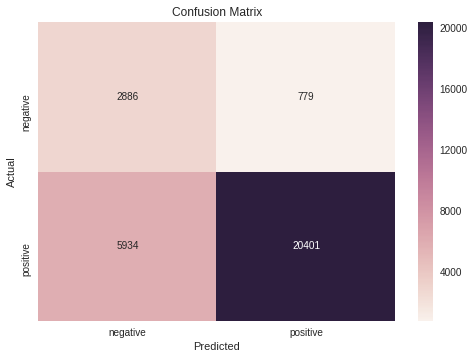

In [53]:
pred = clf.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

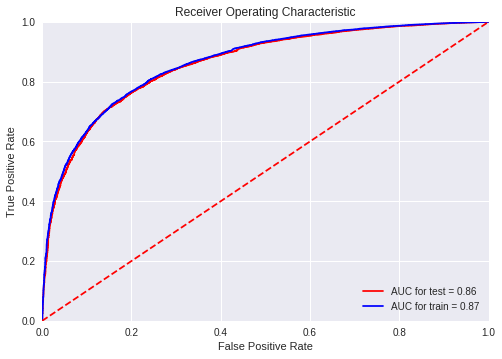

In [54]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Maximum AUC value is  0.8667691802905437
Best Hyperparameter C is : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


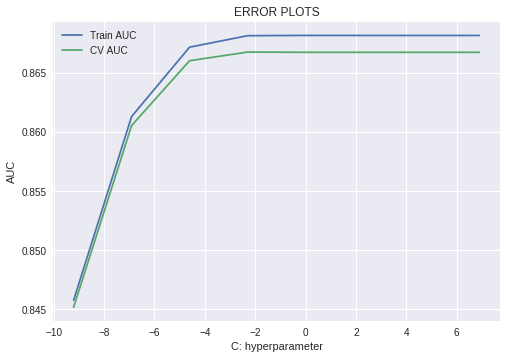

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

neigh=LogisticRegression(penalty='l2' , class_weight='balanced')
parameters = {'C':[pow(10,j) for j in range (-4,4,1)]}
clf=GridSearchCV(neigh , parameters ,cv = 4 , scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train, y_tr)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = C_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter C is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(C_values_log , train_auc ,label='Train AUC')
plt.plot(C_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on CV is :  86.8511159935948


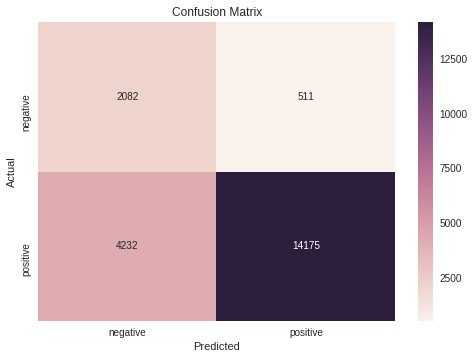

In [56]:
from sklearn.metrics import roc_auc_score

clf= LogisticRegression(penalty='l2' ,C = 0.1 , class_weight='balanced' )
clf.fit(tfidf_sent_vectors_cv , y_cv )
pred = clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score(y_cv , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy on Test is :  86.13760677761168


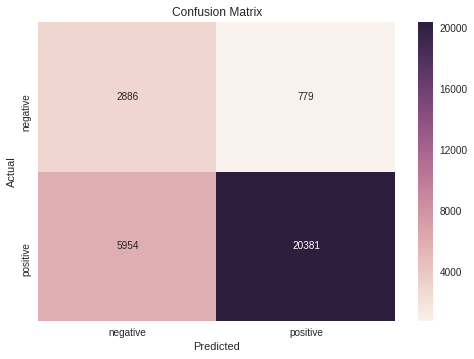

In [57]:
pred = clf.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score(y_test , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

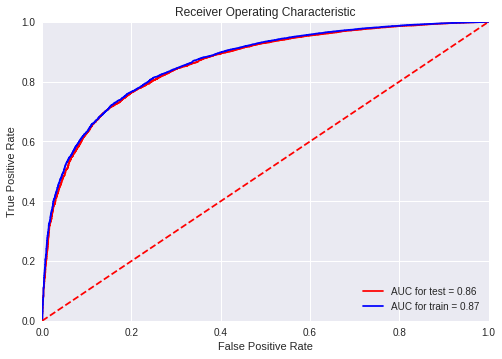

In [58]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= clf.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [69]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Method", " ","L1 Regularization","  ", "","L2 Regularization","   "]

x.add_row(["","HyperParameter","Accuracy on CV","Accuracy on Test","HyperParameter","Accuracy on CV","Accuracy on Test"])
x.add_row(["Bag of Words",0.1,93.75,92.91,0.1,93.91,93.33])
x.add_row(["TF-IDF",1,95.61,95.10,1,95.87,95.53])
x.add_row(["Avg W2V",1,89.52,89.05,0.1,89.51,89.05])
x.add_row(["TF-IDF W2V",1000,86.86,86.12,0.1,86.85,86.13])

print(x)

+--------------+----------------+-------------------+------------------+----------------+-------------------+------------------+
|    Method    |                | L1 Regularization |                  |                | L2 Regularization |                  |
+--------------+----------------+-------------------+------------------+----------------+-------------------+------------------+
|              | HyperParameter |   Accuracy on CV  | Accuracy on Test | HyperParameter |   Accuracy on CV  | Accuracy on Test |
| Bag of Words |      0.1       |       93.75       |      92.91       |      0.1       |       93.91       |      93.33       |
|    TF-IDF    |       1        |       95.61       |       95.1       |       1        |       95.87       |      95.53       |
|   Avg W2V    |       1        |       89.52       |      89.05       |      0.1       |       89.51       |      89.05       |
|  TF-IDF W2V  |      1000      |       86.86       |      86.12       |      0.1       |       8

**1.As we can see from the above table TF-IDF is giving the best roc_auc_score nd hence it is best suitable for our dataset**


**2.There is change between between percentile 99.7 to 99.9 when we were doing multi collinearity Test**

   
**3. If we Check Sparsity**
****
 

  **--------->a)    With C = 0.01 sparsity is 171**  

**--------->b)   With C = 0.1   sparsity is 1102** 

**--------->c)   With C = 1      sparsity is 4018** 

**--------->d)   With C = 10    sparsity is 5893** 

**--------->e)   With C = 100  sparsity is 6647** 









